In [91]:
# ---------------------- IMPORT LIBRARIES --------------------------
import os 
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report,accuracy_score

In [92]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [93]:
# --------------------- HANDLING DIRECTORY -------------------------

# parent folder director
parent_dir = Path.cwd().parent

# data directory
data_dir = parent_dir / "data"

# dataset directory
dataset_dir = data_dir / "Loan_Default.csv"

# Add parent directory to system
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [94]:
# ------- IMPORT PREPROCESSING FUNC ---------

from modules.preprocess_2 import load_and_split_data
from modules.preprocess_2 import get_preprocessing_pipeline
from modules.preprocess_2 import transform_data
from modules.preprocess_2 import get_transformed_df

## BASELINE LOGISTIC REGRESSION

In [95]:
# --------------------- LOAD DATASET ----------------------------
X_train, X_test, y_train, y_test = load_and_split_data(dataset_dir)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (118936, 33), Test shape: (29734, 33)


In [96]:
# ------------------ PREPROCESSING PIPELINE ------------------

preprocessor = get_preprocessing_pipeline()

preprocessor.steps

[('data_cleaning',
  FunctionTransformer(func=<function clean_data at 0x000002841AD6B380>)),
 ('preprocessor',
  ColumnTransformer(transformers=[('log_num',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('log_transform',
                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                   ('scalar', StandardScaler())]),
                                   ['loan_amount', 'income', 'Upfront_charges',
                                    'Interest_rate_spread', 'dtir1']),
                                  ('num',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('scalar', Stan...
                                

In [97]:
X_train_trans, X_test_trans, fitted_pipeline = transform_data()

fitted_pipeline

Pipeline(steps=[('data_cleaning',
                 FunctionTransformer(func=<function clean_data at 0x000002841AD6B380>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('log_num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scalar',
                                                                   StandardScaler())]),
                                                  ['loan_amount', 'income',
                                                   'Upfront_charges...
                                                   'approv_in_adv', 'loan_type',
                                                   'loan_purpose',
                                                   'Credit_Worthiness',
                                                   'open_credit',
                                                   'Neg_ammortization',
                                                   'interest_only',
                                                   'lump_sum_payment',
                                                   'construction_type',
                                                   'occupancy_type',
                                                   'Secured_by', 'total_units',
                                                   'credit_type',
                                                   'co-applicant_credit_type',
                                                   'submission_of_application',
                                                   'Region', 'Security_Type',
                                                   'term',
                                                   'Credit_Score_Group'])])),
                ('final_imputer', SimpleImputer(strategy='median'))])

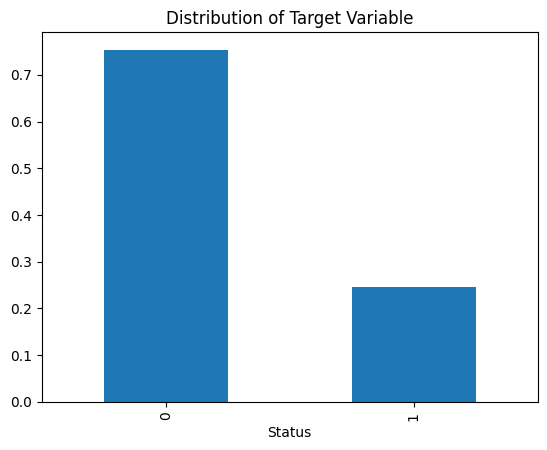

In [98]:
# ------- BALANCE TARGET VARIABLE CHECK -------
# transformed dataframe
df = get_transformed_df()

df["Status"].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Status')
plt.show()

In [99]:
# Logistic Regression Model
model = LogisticRegression(
    C = 0.01,
    solver='liblinear',
    random_state= 42,
    class_weight='balanced',
)

full_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

full_pipeline


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_cleaning',
                                  FunctionTransformer(func=<function clean_data at 0x000002841AD6B380>)),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('log_num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                   ('scalar',
                                                                                    StandardScaler())]),
                                                                   ['loan_a...
                                                                    'lump_sum_payment',
                                                                    'construction_type',
                                                                    'occupancy_type',
                                                                    'Secured_by',
                                                                    'total_units',
                                                                    'credit_type',
                                                                    'co-applicant_credit_type',
                                                                    'submission_of_application',
                                                                    'Region',
                                                                    'Security_Type',
                                                                    'term',
                                                                    'Credit_Score_Group'])])),
                                 ('final_imputer',
                                  SimpleImputer(strategy='median'))])),
                ('model',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [100]:
# ------------ CROSS- VALIDATION & PREDICTION --------------

# Cross-Validation Scores
cross_val_score(
    full_pipeline,
    X_train,
    y_train,
    cv=3,
    scoring='accuracy'
)

array([0.81811532, 0.81357044, 0.81642073])

In [101]:
# Cross-Validated Predictions
y_train_pred = cross_val_predict(
    full_pipeline,
    X_train,
    y_train,
    cv=3
)


cm = confusion_matrix(y_train, y_train_pred)
cm

array([[77140, 12485],
       [ 9395, 19916]])

## HYPERPARAMETER TUNING

In [102]:

# ------------------ HYPERPARAMETER TUNING SETUP (Grid Search) ------------------

# Define the parameter grid for the 'C' value in Logistic Regression
param_grid = {
    'model__C': np.logspace(-3, 2, 6) # Generates [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}


In [103]:
# Initialize GridSearchCV

grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1 
)

In [104]:
# Fit the grid search (this runs 3-fold cross-validation for all 6 C values)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_cleaning',
                                                         FunctionTransformer(func=<function clean_data at 0x000002841AD6B380>)),
                                                        ('preprocessor',
                                                         ColumnTransformer(transformers=[('log_num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('log_transform',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                          ('scalar',...
                                                                                           'submission_of_application',
                                                                                           'Region',
                                                                                           'Security_Type',
                                                                                           'term',
                                                                                           'Credit_Score_Group'])])),
                                                        ('final_imputer',
                                                         SimpleImputer(strategy='median'))])),
                                       ('model',
                                        LogisticRegression(C=0.01,
                                                           class_weight='balanced',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='roc_auc', verbose=2)

In [105]:
# The best estimator is the model (pipeline) that achieved the highest AUC
best_model = grid_search.best_estimator_

In [106]:
# Predict probabilities on the test set using the best model
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Predict classes on the test set
y_pred_test = best_model.predict(X_test)

# Final test set evaluation
final_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nFinal Model (Best C) AUC Score on Test Set: {final_auc:.4f}")

print("\n--- Final Classification Report on Test Set (using Best C) ---")
print(classification_report(y_test, y_pred_test, digits=4))


Final Model (Best C) AUC Score on Test Set: 0.8630

--- Final Classification Report on Test Set (using Best C) ---
              precision    recall  f1-score   support

           0     0.8952    0.8624    0.8785     22406
           1     0.6217    0.6915    0.6547      7328

    accuracy                         0.8203     29734
   macro avg     0.7585    0.7769    0.7666     29734
weighted avg     0.8278    0.8203    0.8234     29734



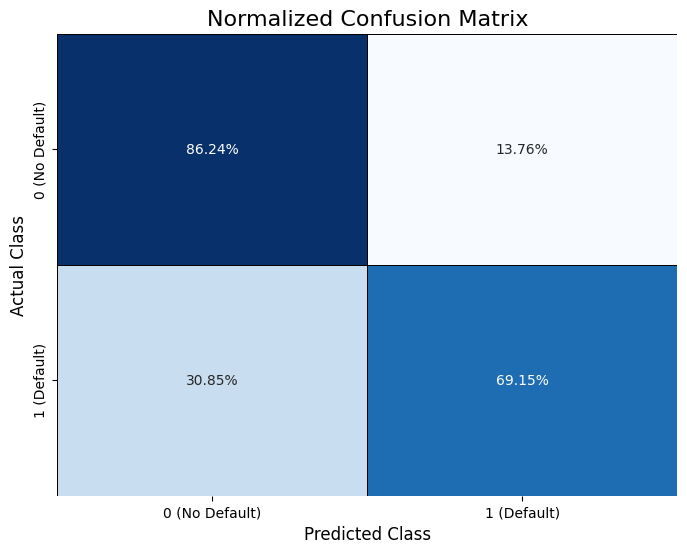

In [107]:
cm = confusion_matrix(y_test, y_pred_test, normalize='true')


class_labels = ['0 (No Default)', '1 (Default)']

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt=".2%", # Format annotations as percentage with 2 decimal places
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels,
    cbar=False,
    linewidths=0.5,
    linecolor='black'
)

plt.title('Normalized Confusion Matrix', fontsize=16)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

## FEATURES IMPORTANCE

In [108]:
df = get_transformed_df()



In [109]:
# remove status from features

df.drop(columns = 'Status', inplace=True)

In [110]:
df.head()

,loan_amount,income,Upfront_charges,Interest_rate_spread,dtir1,LTV,age_numerical,loan_limit_ncf,Gender_Joint,Gender_Male,...,term_312.0,term_322.0,term_324.0,term_336.0,term_348.0,term_360.0,Credit_Score_Group_Fair,Credit_Score_Group_Good,Credit_Score_Group_Poor,Credit_Score_Group_Very Good
141039,-0.555165,0.182800,-0.039564,-2.430172,-3.792472,-2.536675,1.370689,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
121276,0.863453,-0.036221,-0.487360,-0.345545,0.905928,-0.163195,-0.082704,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
11214,0.242313,-0.645258,0.375590,0.080035,1.257591,-1.484969,0.643992,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
129659,-0.177727,0.837130,0.492038,1.096457,0.213504,0.908243,0.643992,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13370,-0.929951,-0.916299,0.588151,-0.103990,1.086738,0.201294,1.370689,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [111]:
best_model.steps

[('preprocessor',
  Pipeline(steps=[('data_cleaning',
                   FunctionTransformer(func=<function clean_data at 0x000002841AD6B380>)),
                  ('preprocessor',
                   ColumnTransformer(transformers=[('log_num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('log_transform',
                                                                     FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                    ('scalar',
                                                                     StandardScaler())]),
                                                    ['loan_amount', 'income',
                                                     'Upfront_charges...
                                                     '

In [112]:
# preprocessing pipeline
preprocessor_step = best_model.named_steps['preprocessor']

# feature names after preprocessing
features = df.columns

# feature importance
feat_importance = best_model.named_steps['model'].coef_[0]

# Pandas Series of feature importance
df_feat = pd.DataFrame(
    {
        'Features': features,
        'Coefficient': feat_importance
    }
).sort_values(by='Coefficient', ascending=True, key=np.abs)

df_feat.head()

,Features,Coefficient
43,term_165.0,0.000291
4,dtir1,-0.000659
31,credit_type_EXP,-0.005618
10,Gender_Sex Not Available,0.010376
49,term_228.0,-0.024554


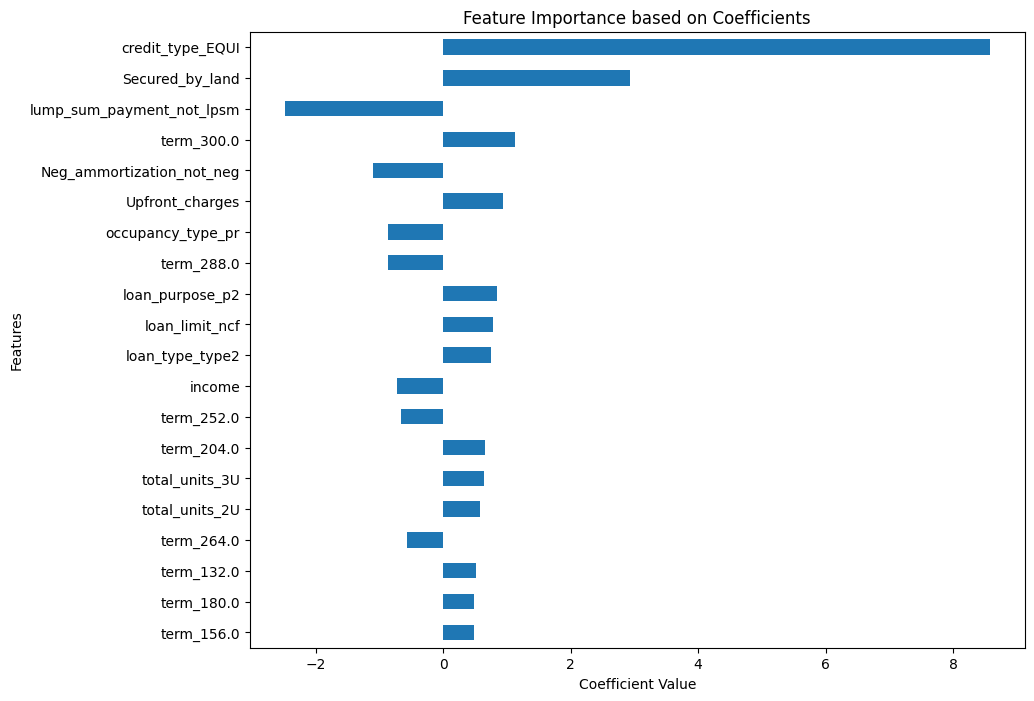

In [113]:
# Plotting feature importance

df_feat.tail(20).plot(kind='barh', x='Features', y='Coefficient', legend=False, figsize=(10,8))
plt.title('Feature Importance based on Coefficients')
plt.xlabel('Coefficient Value')
plt.show()